In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import matplotlib.pyplot as plt
from PIL import Image

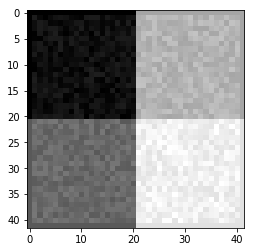

In [2]:
# Diffusion function
g = lambda s: 1/(1+s)


# Create a random test image
def generate_random2D(N, M):
    # Generate image of 4 squares
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    
    # Add noise to picture
    I[1:-1, 1:-1] += np.random.rand(N,M)*20
    return I

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def image_display(V, n, m, cmap = "gray"):
    image = V.reshape(((n, m)))
    plt.imshow(image, cmap)
    plt.show()


# Spatial discretization
M = 40
N = 40
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)


# Number of iteratinos, adn timestep
T = 100
dt = 1e-11
r = dt/(2*(dx**2 + dy**2))

# Generate random image
I = generate_random2D(N, M)
# I = load_image("lena-64x64.jpg")


# Initiate grid
U = np.zeros((T, K))
U[0] = I.reshape(K)

plt.imshow(U[0].reshape(N+2, M+2), cmap = "gray")
plt.show()

In [10]:
# Block matrix x-derivative
Bx = -1 * np.eye(M+2, k = -1) + np.eye(M+2, k = 1)
Bx[0, :2] = [-2, 2]
Bx[-1, -2:] = [-2, 2]

# Differentiation matrix x-direction
Dx = np.zeros((K, K))
for i in range(N+2):
    Dx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Bx  
Dx /= 2*dx

# Differnetiation matrix y-direction
Dy = -np.eye(K, k = -(M+2)) + np.eye(K, k = M+2)
Dy[:(M+2), :2*(M+2)] = np.hstack((-2*np.identity(M+2), 2*np.identity(M+2)))
Dy[-(M+2):, -2*(M+2):] = np.hstack((-2*np.identity(M+2), 2*np.identity(M+2)))
Dy /= 2*dy

G = g(Dx.dot(U[0])**2 + Dy.dot(U[0])**2)

Ξx = np.zeros((K, K))
Ωx = np.zeros((K, K))
Γx = np.zeros((K, K))

Ξy = np.zeros((K, K))
Ωy = np.zeros((K, K))
Γy = np.zeros((K, K))

Xx = np.eye(M+2, M+2, k = -1) + np.eye(M+2, M+2, k = 0)
Xx[0, :2] = 0
Xx[-1, -2:] = 0
Xx

Mx = -np.eye(M+2, k = -1) -2*np.eye(M+2) - np.eye(M+2, k = 1)
Mx[0, :2] = 0
Mx[-1, -2:] = 0
Mx

Fx = np.eye(M+2) + np.eye(M+2, k = 1)
Fx[0, :2] = 0
Fx[-1, -2:] = 0
Fx

for i in range(1, N+1):
    Ξx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Xx

for i in range(1, N+1):
    Ωx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Mx

for i in range(1, N+1):
    Γx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Fx

for i in range(1, N+1):
    Ξy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = np.identity(M)
    Ξy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)

for i in range(1, N+1):
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = -np.identity(M)
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = -2*np.identity(M)
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = -np.identity(M)

for i in range(1, N+1):
    Γy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)
    Γy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = np.identity(M)


In [29]:
# Spatial discretization
M = 62
N = 62
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)
# I = generate_random2D(N, M)
I = load_image("lena-64x64.jpg")
# Number of iteratinos, adn timestep
T = 10
dt = 1e-6
r = dt/(2*(dx**2 + dy**2))

# Generate random image



# Initiate grid
U = np.zeros((T, K))
U[0] = I.reshape(K)

for it in range(T-1):
    
    G = g(Dx.dot(U[it])**2 + Dy.dot(U[it])**2)
    ξx = Ξx.dot(G)
    ωx = Ωx.dot(G)
    γx = Γx.dot(G)

    ξy = Ξy.dot(G)
    ωy = Ωy.dot(G)
    γy = Γy.dot(G)
    
    x_diags = (ξx[1:], ωx, γx[:-1])
    Ax = spsp.diags(x_diags, (-1, 0, 1)).todense()/(2*dx**2)

    y_diags = (ξy[(M+2):], ωy, γy[:-(M+2)])
    Ay = spsp.diags(y_diags, (-(M+2), 0, M+2)).todense()/(2*dy**2)
    A = Ax + Ay
    U[it+1] = (np.identity(K) - r * A).dot(U[it])

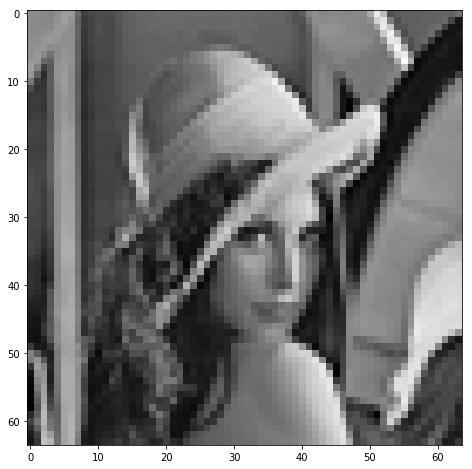

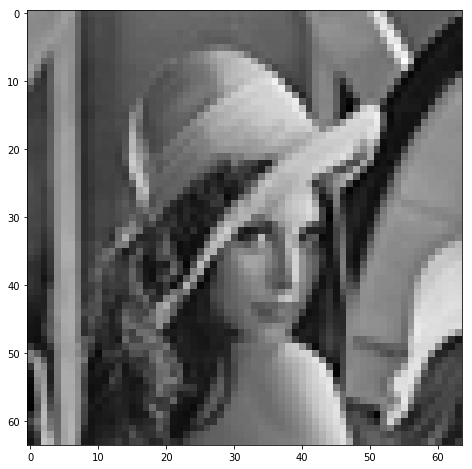

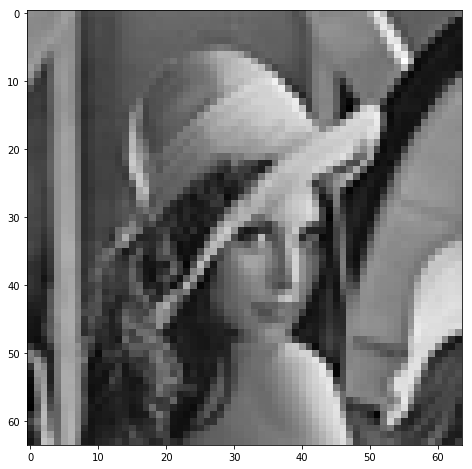

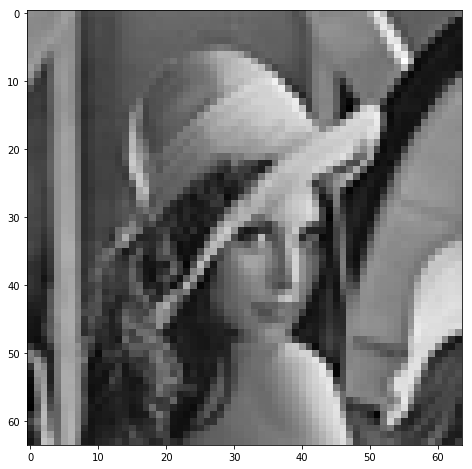

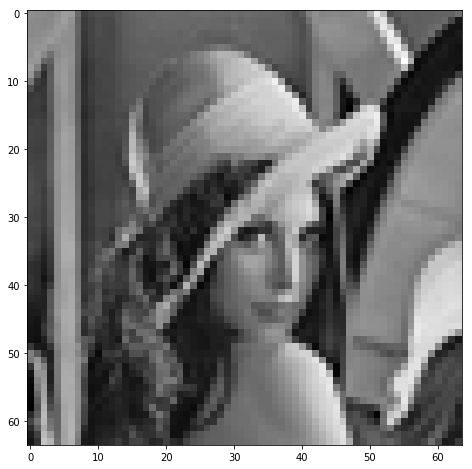

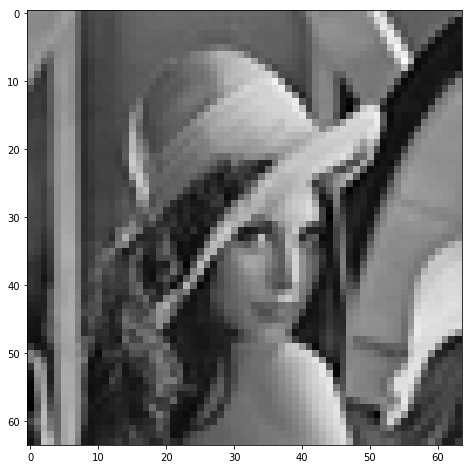

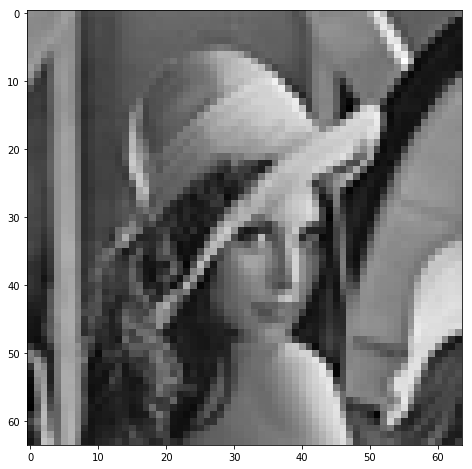

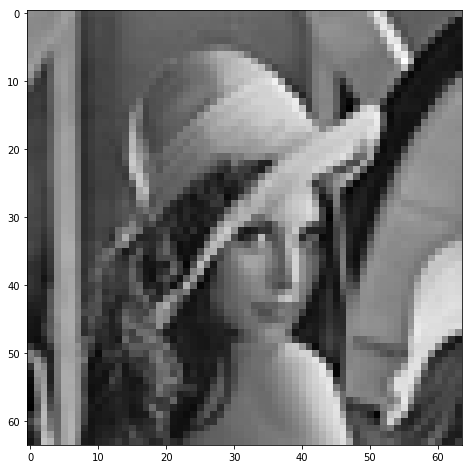

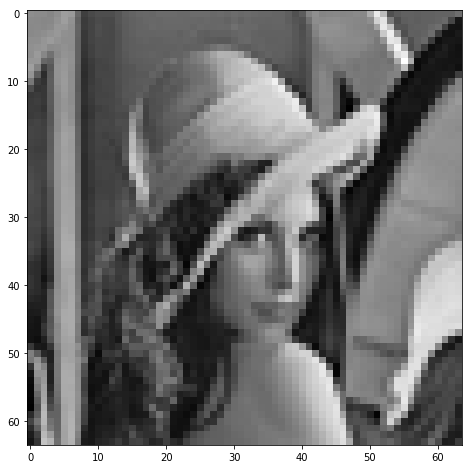

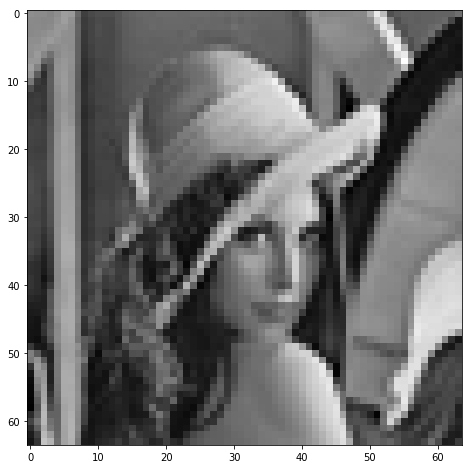

In [30]:
for i in range(10):
    plt.figure(figsize=(12,8))
    plt.imshow(U[U[0].size//9*i).reshape(N+2, M+2), cmap = "gray")
    plt.show()

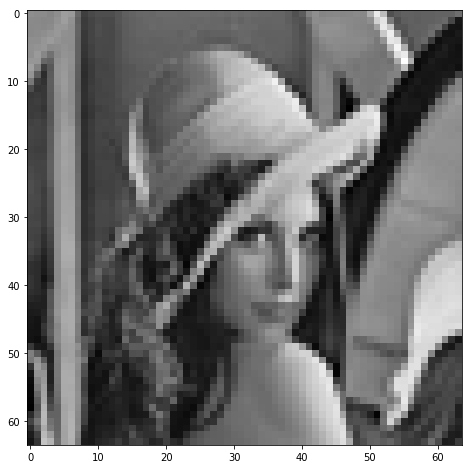

In [14]:
plt.figure(figsize =(12,8))
plt.imshow(U[-1].reshape(N+2, M+2), cmap = "gray")
plt.show()

In [22]:
print(U[0, [0, M+2]]- U[-1, [0, M+2]])

[0. 0.]
